To do:
1. Determine if perturbative series should converge by looking at $\langle \psi_{1,0,0} | V' | \psi_{2,0,0} \rangle$ compared to $\frac{1}{2}|E_2 - E_1|$ using both perturbing approaches for different thicknesses (see [Eq. 1.1.47](https://ocw.mit.edu/courses/physics/8-06-quantum-physics-iii-spring-2018/lecture-notes/MIT8_06S18ch1.pdf)) from Barton Zwiebach's awesome notes.

#### Result: For 2 ML and the 5 ML case $|\langle |\psi_{1,0,0} | V' | \psi_{2,0,0} \rangle|$ >$\frac{1}{2}|E_2 - E_1|$, which suggests the perturbative series will *not* converge.



2. Implement 3rd order correction as long as it appears that the series should converge... Since the results from 1. suggest it will not converge, maybe building Hamiltonian matrix in basis of the 0th order states and diagonalizing (i.e. linear variational method) would be better.

In [1]:
### Reworked code some and now just putting everything in this top block
### to compute 1st and 2nd order corrections
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import genlaguerre
from scipy.special import sph_harm
from scipy.interpolate import UnivariateSpline
from numpy import linalg as LA
from scipy.sparse.linalg import eigs
import math

''' Define various constants here! '''
###  !!!! npl thickness in nanometers, see page 2 of manuscript
#### 2 mL d_nm = 0.7
#### 5 mL = 1.9 nm
d_nm = 1.9

# conversion from nm to atomic units
nm_to_au = 18.89725988579

# d in atomic units
d = d_nm * nm_to_au

# electron-hole reduced mass in atomic units
mu = 0.22
# relative permittivity of NPL... see page 10 of the manuscript
eps_m = 10
# relative permittivity of medium.... see page 10 of the manuscript
eps_sol = 2
# k = 4*pi*epsilon_0 in atomic units
k = 1
# hbar in atomic units
hbar = 1
# electron charge in atomic units
ec = 1

''' It is now unclear to me if we can hard-code the bohr radius and
    still assume that psi_nlm(r,theta,phi; a0) is an eigenfunction of H_0
    so I'm reverting to computing a0 from \mu and \epsilon for now 
# bohr radius in atomic units using Azmain's value
#a0b = 0.82*18.89725988579 

# zeroth order ground state approach B - using Azmain's value of a0, which is a0b
#E_z = -ec**2/(8*np.pi*eps_m * a0b) '''

# a0 = 4*pi*epsilon_0 * epsilon_m * hbar^2 / (mu * e^2)
# in atomic units, everything is 1 except epsilon_m / mu 
a0b = eps_m / mu

# take the two different approaches for computing the ground-state energy
# (1) E_n = -mu * e^4/(n^2 * 2 * (4 pi epsilon_0)^2 epsilon_m^2 \hbar^2)
#     where in atomic units, everything is 1 except
#     E_n = -mu / (n^2 * 2 * epsilon_m^2 )
# 
# (2) E_n = -e^2 / (n^2 * 2 * (4 * pi * epsilon_0) * epsilon_m * a0)
#     where in atomic units, everything is 1 except
#     E_n = -1/(n^2 * 2 * epsilon_m * a0)

def En_using_mu(n, redmass, epsilon_m):
    return -redmass / (n**2 * 2 * epsilon_m**2)

def En_using_a(n, a0, epsilon_m):
    return -1/(n**2 * 2 * epsilon_m * a0)

# get Eg using approach (1)
E1_from_mu = En_using_mu(1, mu, eps_m)
# get Eg using approach (2)
E1_from_a0 = En_using_a(1, a0b, eps_m)

print(" bohr radius in atomic units:",a0b)
print(" bohr radius in nm:",a0b/nm_to_au)
print(" E1 from mu:", E1_from_mu * 27.211 * 1000)
print(" E1 from a0:", E1_from_a0 * 27.211 * 1000)
print(" Difference:",(E1_from_mu-E1_from_a0)*27.211*1000)
print(" Nanoplatlet thickness in nanometers", d_nm)
print(" Nanoplatlet thickness in atomic units", d)



 bohr radius in atomic units: 45.45454545454545
 bohr radius in nm: 2.405351131818084
 E1 from mu: -29.9321
 E1 from a0: -29.9321
 Difference: 0.0
 Nanoplatlet thickness in nanometers 1.9
 Nanoplatlet thickness in atomic units 35.904793783001


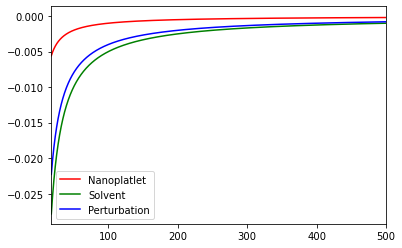

In [2]:
''' Set up grids for the potential and the wavefunction '''
# radius grid in atomic units
r_perturb = np.linspace(d/2, 5000, 50000)
r_array = np.linspace(1e-9, 5000, 50000)
# theta grid
th = np.linspace(0, np.pi, 100)
# phi grid
phi = np.linspace(0, 2*np.pi, 100)

# perturbing potential
V_perturb = ec**2 * (eps_sol - eps_m)/(k*eps_sol*eps_m*r_perturb)
# potential in nanoplatlet
Vnp = -ec**2/(k * eps_m * r_perturb)
# potential in solvent 
Vsol = -ec**2/(k*eps_sol * r_perturb)


plt.plot(r_perturb, Vnp, 'red', label="Nanoplatlet")
plt.plot(r_perturb, Vsol, "green", label="Solvent")
plt.plot(r_perturb, V_perturb, "blue", label="Perturbation")
plt.xlim(d/2, 500)
plt.legend()
plt.show()

In [3]:
# To get perturbative corrections, we need to be able to generate
# 0th-order eigenfunctions and eigenenergies!  

# 0th order eigenfunction radial part
def R(n,l,r, a0):
    '''Returns the radial wavefunction for each value of r where n is the principle quantum number 
         and l is the angular momentum quantum number.'''
    norm = np.sqrt( (2/(n*a0))**3 * math.factorial(n - l - 1)/(math.factorial(n+l) * 2 * n))
    t1 = np.exp(-r/(n*a0))
    t2 = (2*r/(n*a0))**l
    #Generates an associated laguerre polynomial as a scipy.special.orthogonal.orthopoly1
    Lag = genlaguerre(n-l-1, 2*l+1)
    t3 = Lag(2*r/(n*a0))
    return norm * t1 * t2 * t3

def test_norm(n, l, r, theta, a0):
    # bra state
    R_bra = R(n, l, r, a0)
    Y_bra = sph_harm(0, l, 0, theta)
    
    R_integrand = np.conj(R_bra) * R_bra * r * r
    Y_integrand = np.real(np.conj(Y_bra) * Y_bra * np.sin(theta))
    
    R_integral = np.trapz(R_integrand, r)
    Y_integral = np.trapz(Y_integrand, theta)
    return 2*np.pi*R_integral*Y_integral

# return matrix element of Hamiltonian for linear variational method
# there are two terms contributing to <\psi_n,l,m | H | \psi_n',l',m'>:
# = <\psi_n,l,m | H_0 | \psi_n',l',m'> + <\psi_n,l,m | Vp | \psi_n',l',m'>
# = E_n' * delta_{n,n'} * delta_{l,l'} * delta_{m, m'} + <\psi_n,l,m | Vp | \psi_n',l',m'>
def H_ij(bra_n, bra_l, ket_n, ket_l, Vp, r, theta, a0, npl_thickness, epsilon_m):
    ''' We can factor the integral over phi from the integral over theta and r...
        plus integral over theta and r just becomes integral over r weighted by
        the slices of theta that extend outslide the platlet since we cannot couple
        m != 1 states to the psi_100 state through this potential, so the
        0th-order eigenfunctions are all constants along \theta!!!! '''
    
    Ej = 0
    # Get easy part if bra and ket are the same!
    if (bra_n==ket_n and bra_l == ket_l):
        #Ej = En_using_mu(ket_n, mu, eps_m)
        Ej = En_using_a(ket_n, a0, epsilon_m)
    
    ### get 0th-order ket terms
    R_bra = R(bra_n, bra_l, r, a0)
    Y_bra = sph_harm(0, bra_l, 0, theta)
    
    ### get 0th-order bra terms
    R_ket = R(ket_n, ket_l, r, a0)
    Y_ket = sph_harm(0, ket_l, 0, theta)
    
    #plt.plot(theta, np.conj(Y_bra)*Y_ket * np.sin(theta) , 'green')
    #plt.show()
    
    ### compute integrand over theta
    Y_integrand = np.real(np.conj(Y_bra) * Y_ket * np.sin(theta))
    ### fit spline to integrand over theta
    Y_spline = UnivariateSpline(theta, Y_integrand)
    fac_phi = 2*np.pi
    
    dE = 0
    dr = r[1]-r[0]
    for i in range(0,len(r)):
        th_max = np.arccos(npl_thickness/(2*r[i]))
        fac_theta_up = Y_spline.integral(0, th_max)
        fac_theta_down = Y_spline.integral(np.pi-th_max, np.pi)
        fac_theta = fac_theta_up + fac_theta_down
        dE += R_bra[i] * R_ket[i] * r[i]**2 * Vp[i] * dr * fac_theta
        
    return Ej + fac_phi * dE



#  return <\psi_100 | V' | psi_nl0 >

def pt2_nl(n, l, Vp, r, theta, a0, npl_thickness):
    ''' We can factor the integral over phi from the integral over theta and r...
        plus integral over theta and r just becomes integral over r weighted by
        the slices of theta that extend outslide the platlet since we cannot couple
        m != 1 states to the psi_100 state through this potential, so the
        0th-order eigenfunctions are all constants along \theta!!!! '''
    
    ### get 0th-order ket terms
    R_bra = R(1, 0, r, a0)
    Y_bra = sph_harm(0, 0, 0, theta)
    
    ### get 0th-order bra terms
    R_ket = R(n, l, r, a0)
    Y_ket = sph_harm(0, l, 0, theta)
    
    #plt.plot(theta, np.conj(Y_bra)*Y_ket * np.sin(theta) , 'green')
    #plt.show()
    
    ### compute integrand over theta
    Y_integrand = np.real(np.conj(Y_bra) * Y_ket * np.sin(theta))
    ### fit spline to integrand over theta
    Y_spline = UnivariateSpline(theta, Y_integrand)
    fac_phi = 2*np.pi
    
    dE = 0
    dr = r[1]-r[0]
    for i in range(0,len(r)):
        th_max = np.arccos(d/(2*r[i]))
        fac_theta_up = Y_spline.integral(0, th_max)
        fac_theta_down = Y_spline.integral(np.pi-th_max, np.pi)
        fac_theta = fac_theta_up + fac_theta_down
        dE += R_bra[i] * R_ket[i] * r[i]**2 * Vp[i] * dr * fac_theta
        
    return fac_phi * dE





In [4]:
# Build the possible quantum numbers n and l into a list (m is always zero!)
# figure out the size of the Hamiltonian matrix for all psi_n,l,0 basis states up to n_max:
qn = []
n_max = 4
for n in range(n_max):
    for l in range(0, n):
        qn.append((n, l))
        
print(qn)
print(len(qn))
dim = len(qn)
Hmat = np.zeros((dim, dim))

[(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2)]
6


In [5]:
# Form matrix elements of shifted CIS Hamiltonian
for i, bra_qn in enumerate(qn):
    bn, bl = bra_qn
    for j, ket_qn in enumerate(qn):
        kn, kl = ket_qn
        Hmat[i, j] = H_ij(bn, bl, kn, kl, V_perturb, r_perturb, th, a0b, d, eps_m)

            

print(Hmat)

[[-5.13479539e-03 -4.24214384e-04  6.65275160e-19 -1.97979947e-04
   3.57375870e-19 -1.92561509e-05]
 [-4.24214384e-04 -1.87926462e-03 -2.79632803e-19 -3.40218452e-04
   3.33071454e-20  1.44656134e-05]
 [ 6.65275160e-19 -2.79632803e-19 -2.28246081e-03 -6.20596437e-20
  -4.65868103e-04 -2.85339173e-19]
 [-1.97979947e-04 -3.40218452e-04 -6.20596437e-20 -9.23685949e-04
  -1.46457647e-19  4.67961413e-06]
 [ 3.57375870e-19  3.33071454e-20 -4.65868103e-04 -1.46457647e-19
  -1.03884507e-03  1.34847489e-19]
 [-1.92561509e-05  1.44656134e-05 -2.85339173e-19  4.67961413e-06
   1.34847489e-19 -1.05806662e-03]]


In [6]:
### Diagonalize Hmat and print eigenvalues!
vals, vecs = LA.eigh(Hmat)
print(vals*27.211*1000)


[-141.57186342  -66.33008318  -52.2820604   -28.77921543  -24.04597115
  -22.15191658]


 Note <r> for R_10^{(0)} should be 3/2 * a0 or 68.18181818181819 atomic units
 <r> for 0th order: 68.18181818196018
 <r> for variational 64.39080253161042


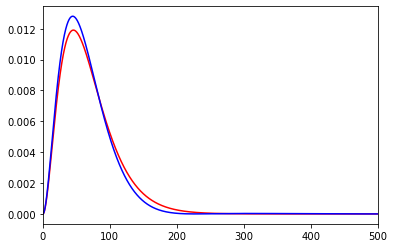

In [7]:
R_zero_order = R(1, 0, r_array, a0b)
R_variational = np.zeros_like(R_zero_order)

for i, bra_qn in enumerate(qn):
    bn, bl = bra_qn
    R_variational += vecs[i,0] * R(bn, bl, r_array, a0b)

Norm_z0 = np.trapz(R_zero_order**2 * r_array**2, r_array)
Norm_var = np.trapz(R_variational**2 * r_array**2, r_array)

r_num_z0 = np.trapz(R_zero_order**2 * r_array**3, r_array)
r_num_var = np.trapz(R_variational**2 * r_array**3, r_array)

r_expt_z0 = r_num_z0 / Norm_z0

r_expt_var = r_num_var / Norm_var

print(" Note <r> for R_10^{(0)} should be 3/2 * a0 or", a0b*3/2,"atomic units")
print(" <r> for 0th order:", r_expt_z0)
print(" <r> for variational", r_expt_var)


#R_zero_order *= (1/Norm_z0)
#R_first_order *= (1/Norm_f0)
plt.plot(r_array, R_zero_order**2*r_array**2, 'red')
plt.plot(r_array, R_variational**2*r_array**2, 'blue')
plt.xlim(0, 500)
plt.show()

### Perturbative correction to dielectric screening of the coulomb potential

We assume that within the nanoplatlet and in the solvent, the exciton experiences a coulomb potential that is screened by the dielectric constant of the nanoplatlet and solvent, respectively.  In the coordinate system of the exciton that has thickness $d$ along the $z$ axis, the columb potential can be written as

$$ V_{npl}(r) = -\frac{e^2}{4\pi \epsilon_{npl}\epsilon_0 r} \; \; {\rm when} \; |r \: {\rm cos}(\theta)| \leq \frac{d}{2} $$

while in the solvent, the potential has the same coulomb form but is screened by the dielectric of the solvent rather than the nanoplatlet:

$$ V_{sol}(r) = -\frac{e^2}{4\pi \epsilon_{sol}\epsilon_0 r} \; \; {\rm when} \; |r \: {\rm cos}(\theta)| > \frac{d}{2}.$$

The ground state energy of the exciton to 2$^{nd}$ order in perturbation theory then is 

$$ E_g = E_1^{(0)} + E_1^{(1)} + E_1^{(2)}, $$
and the binding energy is 
$$ E_B = -E_g \equiv -E_1^{(0)} - E_1^{(0)} - E_1^{(2)}.$$

Here we assume 

$$ \hat{H}_0 = -\frac{\hbar^2}{2\mu} \nabla^2 + V_{npl}(r) $$
where $\mu = \frac{m_e \cdot m_h}{m_e + m_h}$ and is taken to be 0.22 $m_e$ in this work.    

$E_1^{(0)}$ is the ordinary 3D hydrogen ground state energy with $\epsilon_{npl}$ screening the coulomb potential and the electron mass replaced by $\mu$.  We compute $E_1^{(0)}$ as follows:


$$ E_1^{(0)}  =  -\frac{ e^2}{8\pi\epsilon_{npl} \epsilon_0 a_0 }. $$

The first-order energy correction can be written as

$$ E_1^{(1)} = \int_0^{\infty} r^2 dr \int_0^{\pi}{\rm sin}\left( \theta \right) d\theta   \int_0^{2\pi} d\phi  \: \psi^{(0)*}_{100} (r, \theta, \phi) V'(r,\theta) \psi^{(0)}_{100} (r, \theta, \phi),  $$

where 
\begin{align} 
V'(r,\theta) &= \left(V_{sol}(r) - V_{npl}(r)\right) H(|r \: {\rm cos}(\theta)|-\frac{d}{2}) \\
V'(r,\theta) &= \frac{e^2\left(\epsilon_{sol}-\epsilon_{npl} \right)}{4\pi \epsilon_{sol}\epsilon_{npl}\epsilon_0 r} H(|r \: {\rm cos}(\theta)|-\frac{d}{2}),
\end{align}
where $H(|r \: {\rm cos}(\theta)|-\frac{d}{2})$ is the Heaviside function that turns the perturbating potential on for regions of the excitonic coordinate the extend beyond the nanoplatlet.


The zeroth-order ground-state wavefunction is

$$ \psi^{(0)}_{1,0,0}(r,\theta, \phi) = \frac{1}{\sqrt{\pi}} \left( \frac{Z}{a_0}\right)^{3/2} e^{-Zr/a_0} \equiv R_{1,0}(r) Y_0^0(\theta, \phi), $$
where

$$a_0 = \frac{4 \pi \epsilon_{npl} \epsilon_0 \hbar^2}{\mu e^2} $$ 

and $Z = 1$.

$R_{1,0}$ is the Hydrogenic $1s$ radial function,
and $Y_{0,0}$ is the Spherical harmonic with $l=0, m=0$.
We can factor out the integral over $\phi$ 
and parameterize the range of integration 
over $\theta$ in terms of $r$:

$$ E_1^{(1)} =  2\pi  \int_{d/2}^{\infty} dr  \: r^2  R_{1,0}^2(r) V'(r) \left(\int_0^{f(r)} d\theta \:{\rm sin}(\theta) |Y_{0,0}(\theta, 0)|^2 +  \int_{\pi - f(r)}^{\pi} d\theta \:{\rm sin}(\theta) |Y_{0,0}(\theta, 0)|^2 \right),  $$

where $f(r) = {\rm cos}^{-1}\left(\frac{d}{2r} \right).$

The second-order energy correction can be written
\begin{align}
& E_1^{(2)} = \sum_{n,l} \frac{2\pi}{E_1^{(0)}-E_n^{(0)}} \times \\
&\int_{d/2}^{\infty} dr  \: r^2  R_{1,0} V'(r) R_{n,l} \left(\int_0^{f(r)} d\theta \:{\rm sin}(\theta) Y^*_{0,0}(\theta, 0)Y_{l,0}(\theta, 0) +  \int_{\pi - f(r)}^{\pi} d\theta \:{\rm sin}(\theta) Y^*_{0,0}(\theta, 0)Y_{l,0}(\theta, 0) \right).
\end{align}
